### Import necessary libraries

In [2]:
from google.colab import drive
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
import random
from torchsummary import summary
from torch.utils.data.dataloader import DataLoader
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as torch_model
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

### Load Data
- I will be using os to load my data which is present in drive.
- The goal of the project is to train a model to classify indoor scenes.
- The Dataset has 67 categories like bedroom, kitchen, garage, game room, airport, salon etc. and each category has at least 100 images and 15,620 RGB images totally. The size of the data is 2GB.

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')
data_dir  = 'Images'
classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['trainstation', 'elevator', 'buffet', 'inside_subway', 'subway', 'closet', 'garage', 'auditorium', 'deli', 'winecellar', 'hairsalon', 'nursery', 'mall', 'bar', 'inside_bus', 'kitchen', 'kindergarden', 'airport_inside', 'waitingroom', 'warehouse', 'movietheater', 'gym', 'locker_room', 'artstudio', 'museum', 'videostore', 'poolinside', 'operating_room', 'livingroom', 'computerroom', 'hospitalroom', 'prisoncell', 'cloister', 'shoeshop', 'studiomusic', 'clothingstore', 'library', 'jewelleryshop', 'fastfood_restaurant', 'classroom', 'dining_room', 'bookstore', 'laboratorywet', 'bowling', 'tv_studio', 'laundromat', 'restaurant_kitchen', 'lobby', 'grocerystore', 'casino', 'bathroom', 'stairscase', 'children_room', 'bakery', 'dentaloffice', 'office', 'toystore', 'gameroom', 'corridor', 'greenhouse', 'concert_hall', 'pantry', 'restaurant', 'meeting_room', 'church_inside', 'florist', 'bedroom']


In [4]:
print("The categories : ", sorted(classes))
print("The categories of images : ", len(classes))

The categories :  ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']
The categories of images :  67


### TorchVision Package
-  Using TorchVision Package to load and Preapare the data. Also,compose function from transforms creates a series of transformation to the prepare the dataset. Resizing the image into 256,256 and transform to tensors.

In [5]:
images_transform = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
data = ImageFolder(data_dir, transform = images_transform)

labels:  casino, livingroom, classroom, bookstore, winecellar, bathroom, florist, garage, laboratorywet, bookstore, 

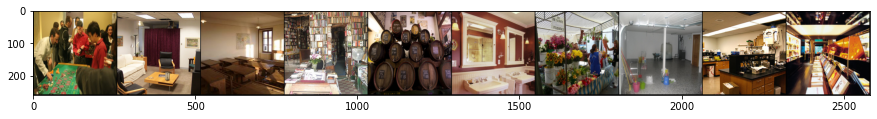

In [6]:
demo_loader = torch.utils.data.DataLoader(data, batch_size=10,shuffle=True)
batch = next(iter(demo_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(data.classes[label], end=", ")

### Train & Test Split
- Next, let's use the random_split helper function to set aside 3000 images for our test set.


In [7]:
train_data,test_data = random_split(data, [14762, 1000])
len(train_data),len(test_data)

(14762, 1000)

In [8]:
from torch.utils.data.dataloader import DataLoader

In [9]:
train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=25,
        num_workers=4,
        shuffle=True,
        pin_memory = True,
    )
test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=25*2,
        num_workers=4,
        shuffle=False,
        pin_memory = True,
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Evaluation Metric and Loss Function¶
- Let's first define the evaluation metric, its important to see how well our model is performing.The best. way to check is to the accuracy of the prediction.

- Loss functions are used to optimize the model during training. The objective is almost always to minimize the loss function. The lower the loss the better the model. Cross-Entropy loss is a most important cost function. It is used to optimize classification models.

- Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.
-  PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package.

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MultiClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

### ResNet
- A residual network (ResNet), is an artificial neural network that helps to build deeper neural network by utilizing skip connections or shortcuts to jump over some layers. It's skipping helps build deeper network layers without falling into the problem of vanishing gradients. 

### Transfer learning
- The main aim of transfer learning (TL) is to implement a model quickly. To solve the current problem, instead of creating neural network from scratch, the model will transfer the features it has learned from the different dataset that has performed the same task. This transaction is also known as knowledge transfer.
- Added a fully-connected layer for classification, specifying the classes and number of features and also tunned the parameters.


In [11]:
class ResNetModel(MultiClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torch_model.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(data.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNetModel()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Using a GPU

- As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

### Model Training

In [13]:
@torch.no_grad()
def evaluate(model, test_dataloader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dataloader, test_dataloader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, test_dataloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)
to_device(model, device)

ResNetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

- Before training the model,need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). 

In [15]:
model = to_device(ResNetModel(), device)

- Print Summary of the model

In [16]:
from torchsummary import summary
summary(model, input_size=(3, 7,7), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

### Evaluation 
- Now, Let's see how the model performs on the test set with the initial set of weights and biases.

In [17]:
evaluate(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.007999999448657036, 'val_loss': 4.218709468841553}

- The initial accuracy is pretty low, so need to train the model. Let's train for 11 epochs and evaluate the performance for learning of 0.00006.

In [18]:
model_fit = fit(11,0.00006, model, train_dataloader, test_dataloader,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 3.7054, val_loss: 3.5081, val_acc: 0.6210
Epoch 2: train_loss: 3.4532, val_loss: 3.4303, val_acc: 0.6800
Epoch 3: train_loss: 3.3675, val_loss: 3.4009, val_acc: 0.7060
Epoch 4: train_loss: 3.3180, val_loss: 3.4015, val_acc: 0.7110
Epoch 5: train_loss: 3.2903, val_loss: 3.3900, val_acc: 0.7290
Epoch 6: train_loss: 3.2733, val_loss: 3.3920, val_acc: 0.7490
Epoch 7: train_loss: 3.2644, val_loss: 3.3974, val_acc: 0.7440
Epoch 8: train_loss: 3.2574, val_loss: 3.4056, val_acc: 0.7630
Epoch 9: train_loss: 3.2523, val_loss: 3.4224, val_acc: 0.7350
Epoch 10: train_loss: 3.2486, val_loss: 3.4199, val_acc: 0.7730
Epoch 11: train_loss: 3.2468, val_loss: 3.4165, val_acc: 0.7580


### Plot Accuracy Vs Number of Epochs

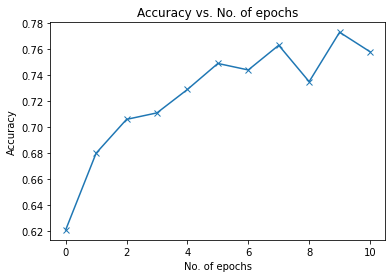

In [19]:
accuracies = [x['val_acc'] for x in model_fit]
plt.plot(accuracies, '-x')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs');

In [20]:
evaluate(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.7580000162124634, 'val_loss': 3.4165031909942627}

In [21]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return data.classes[preds[0].item()]

Label: inside_subway , Predicted Scene: inside_subway


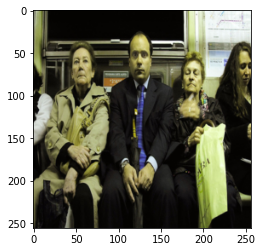

In [22]:
img, label = test_data[545]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted Scene:', predict_image(img, model))

Predicted Scenes :  inside_subway
Original Scenes:  bowling, dentaloffice, inside_subway, bedroom, bar, inside_bus, inside_bus, jewelleryshop, inside_subway, bar, 

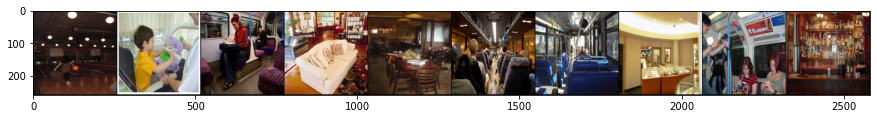

In [32]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10,shuffle=True)
batch = next(iter(test_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Original Scenes: ", end=" ")
for i, label in enumerate(labels):
    print("Predicted Scenes : ",predict_image(img, model))
    print(data.classes[label], end=", ")

In [23]:
loaded_model = model

Predcited Scene:  bar.


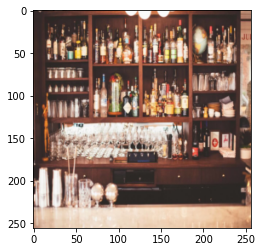

In [24]:
image = Image.open(Path('./' + "bar.jpg"))
example_image = images_transform(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predcited Scene: ", predict_image(example_image, loaded_model) + ".")

Predcited Scene:  children_room.


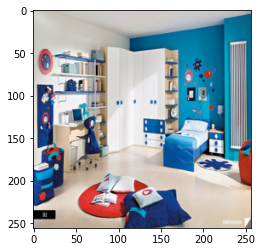

In [25]:
image = Image.open(Path('./' + "bd.jpg"))
example_image = images_transform(image)
plt.imshow(example_image.permute(1, 2, 0))
print("Predcited Scene: ", predict_image(example_image, loaded_model) + ".")

In [26]:
def pytorch_predict(model, test_loader, device):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    count = 0
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data1 in test_loader:
            inputs = [i.to(device) for i in data1[:-1]]
            labels = data1[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    for i in range(0,1000):
         if (data.classes[y_true[i].item()] != data.classes[y_pred[i].item()]):
             count+=1
             print("The scene is ",data.classes[y_true[i].item()],"but predicted as", data.classes[y_pred[i].item()])
    print("Total number of wrongly predicted observations from test data are :", count)

In [27]:
pytorch_predict(model, test_dataloader, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The scene is  church_inside but predicted as winecellar
The scene is  shoeshop but predicted as inside_subway
The scene is  library but predicted as toystore
The scene is  auditorium but predicted as movietheater
The scene is  artstudio but predicted as kitchen
The scene is  buffet but predicted as florist
The scene is  operating_room but predicted as bedroom
The scene is  mall but predicted as casino
The scene is  bookstore but predicted as bar
The scene is  bar but predicted as restaurant
The scene is  operating_room but predicted as hospitalroom
The scene is  grocerystore but predicted as bakery
The scene is  toystore but predicted as deli
The scene is  pantry but predicted as bakery
The scene is  airport_inside but predicted as fastfood_restaurant
The scene is  concert_hall but predicted as grocerystore
The scene is  corridor but predicted as warehouse
The scene is  locker_room but predicted as warehouse
The scene is  casino but predicted as bar
The scene is  children_room but pred